### A hierarchical model

Suppose ***scholastic aptitude (SA)***, denoted $u$, is distributed normally in the population with mean $\mu_0$ and variance $\sigma_0^2$:
$$
u\sim N(\mu_0, \sigma_0^2)
$$

The random variable $u$ is ***latent*** &mdash; unobservable.

A person's ***Scholastic Aptitute Test (SAT)*** score, denoted $y$, is supposed to reflect their scholastic aptitute $u$. Assume:
$$
y\mid u \sim N(u, \sigma^2)
$$
Thus, $\sigma$ is a reflection of the SAT's measurement error.

Variance in SAT score in the population has two sources: variation in SA across the population ($\sigma_0$) and variation in SAT scores among people with the same SA ($\sigma$). By *The Theory*, these two sources of variation combine additively:
$$
y\sim N(\mu_0,\sigma_0^2 + \sigma^2)
$$

### An application of Bayes' Theorem

What can we say about someone's SA if we know their test score? More precisely, what is $p(u\mid y)$?

By Bayes' Theorem,
$$
p(u\mid y) = \frac{p(y\mid u)p(u)}{p(y)}.
$$

We know $p(u)$, $p(y\mid u)$, and $p(y)$. With some algebraic perseverance, we manipulate the right hand side of the the above identify into standard Gaussian form and identify its mean and variance.

Set
$$
\tau_0 = \frac1{\sigma_0},\qquad \tau= \frac1{\sigma}.
$$
The reciprocal variances $\tau_0^2$ and $\tau$^2 are called ***precisions***.

We have:
$$
\begin{aligned}
\mathbb{E}[u\mid y] &= \frac{\tau_0^2}{\tau_0^2 + \tau^2}\mu_0 + \frac{\tau^2}{\tau_0^2 + \tau^2}y\\
\mathbb{V}[u\mid y] &= \frac{1}{\tau_0^2 + \tau^2}
\end{aligned}
$$

Let $\theta$ be the ratio of uncertainty in scholastic aptitude to uncertainty in SAT results.
$$
\theta = \frac{\sigma_0}{\sigma} = \frac{\tau}{\tau_0}.
$$
(The larger $\theta$ is, the more reliable the SAT for capturing the latent SA quantity.)

Setting
$$
t = \frac{1}{1 + \theta^2}
$$
we have
$$
\mathbb{E}[u\mid y] = t\mu_0 + (1 - t)y.
$$

The expression on the right hand side lies between $\mu_0$ and $y$.

If $\theta$ is small, $\mathbb{E}[u\mid y]$ is close to $\mu_0$. Makes sense: If $\theta$ is small then the SAT score $y$ isn't a reliable reflection of SA $u$ we hedge our bet for $u$ towards the population mean.

If $\theta$ is big, $\mathbb{E}[u\mid y]$ is close to $y$. Makes sense: If $\theta$ is big then the SAT score $y$ is a reliable reflection of SA $u$ and we don't need to hedge our bets.


### More generally

You might draw many $y$ subordinate to the same draw of $u$:

$$
\begin{aligned}
u_i&\sim N(\mu_0, \sigma_0^2),&&i<m,\\
y_{ij}\mid u_i &\sim N(u_i,\sigma^2),&&j < n_i
\end{aligned}
$$

Two draws $y_{ij}$ and $y_{ij'}$ are identically distributed and conditionally independent, given $u_i$, but not independent.

Later, we'll discuss how to estimate the parameters of such a model 

In [52]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from statsmodels.api import MixedLM
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


mu0 = 20
sigma0 = 5
sigma = 3
m = 7

cat_dtype = pd.CategoricalDtype(categories=np.arange(m))


def make_data(n, rng=None):
    rng = np.random.default_rng(rng)
    u = rng.normal(mu0, sigma0, size=m)
    i = rng.choice(range(m), size=n)
    y = rng.normal(u[i], sigma)
    df = pd.DataFrame({"y": y, "i": i, "Intercept": 1})
    df["i"] = df["i"].astype(cat_dtype)
    return df


df_train = make_data(30)
df_test = make_data(10_000)
df_train.head()

,y,i,Intercept
0,17.500510,0,1
1,30.510661,6,1
2,14.099756,4,1
3,20.082010,3,1
4,16.329387,1,1


In [53]:
y_train = df_train["y"]
X_train = pd.get_dummies(df_train["i"])
assert X_train.shape[1] == 7

y_test = df_test["y"]
X_test = pd.get_dummies(df_test["i"])
assert X_train.shape[1] == 7

lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(X_train, y_train)
test_mse = mean_squared_error(y_test, lr_model.predict(X_test))
test_mse

49.14887433608354

In [57]:
mixed_model = MixedLM(df_train["y"], df_train[["Intercept"]], groups=df_train["i"])
fit = mixed_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: y       
No. Observations: 30      Method:             REML    
No. Groups:       7       Scale:              9.0400  
Min. group size:  2       Log-Likelihood:     -82.2354
Max. group size:  7       Converged:          Yes     
Mean group size:  4.3                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   21.200    1.994 10.629 0.000 17.291 25.109
Group Var   25.395    5.941                           
======================================================

"""

In [55]:
assert np.allclose(df_train.groupby("i", observed=False)["y"].mean(), lr_model.coef_)

In [42]:
mixed_preds = fit.params["Intercept"] + df_test["i"].map(
    lambda i: fit.random_effects[i]["Group Var"]
).astype(float)
test_mse = mean_squared_error(y_test, mixed_preds)
test_mse

136.45090563906143

In [45]:
fe_mses = []
re_mses = []

for _ in range(1000):
    df_train = make_data(30)
    y_train = df_train["y"]
    X_train = pd.get_dummies(df_train["i"])
    assert X_train.shape[1] == 7

    y_test = df_test["y"]
    X_test = pd.get_dummies(df_test["i"])
    assert X_train.shape[1] == 7

    lr_model = LinearRegression(fit_intercept=False)
    lr_model.fit(X_train, y_train)
    assert np.allclose(
        df_train.groupby("i", observed=False)["y"].mean().fillna(0.0), lr_model.coef_
    )
    fe_mse = mean_squared_error(y_test, lr_model.predict(X_test))
    fe_mses.append(fe_mse)

    mixed_model = MixedLM(df_train["y"], df_train[["Intercept"]], groups=df_train["i"])
    fit = mixed_model.fit()

    mixed_preds = fit.params["Intercept"] + df_test["i"].map(
        lambda i: fit.random_effects[i]["Group Var"] if i in fit.random_effects else 0.0
    ).astype(float)
    re_mse = mean_squared_error(y_test, mixed_preds)
    re_mses.append(re_mse)

/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Li

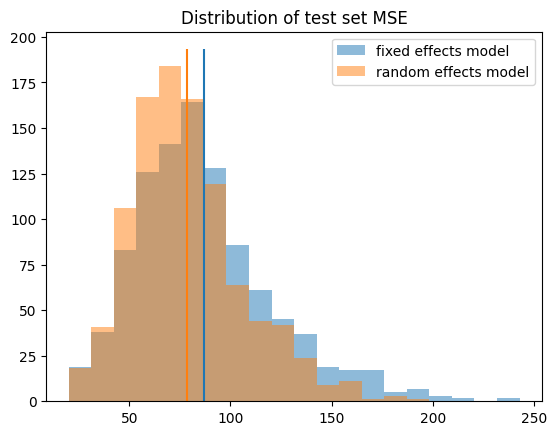

In [46]:
_, bins, __ = plt.hist(fe_mses, bins=20, alpha=0.5, label="fixed effects model")
plt.hist(re_mses, bins=bins, alpha=0.5, label="random effects model")
plt.vlines([np.mean(fe_mses), np.mean(re_mses)], *plt.ylim(), colors=["C0", "C1"])
plt.title("Distribution of test set MSE")
plt.legend()
plt.show()

In [50]:
fit.bse_re

Group Var    1.730918
dtype: float64

In [51]:
fit.bse

Intercept    1.103618
Group Var    0.532956
dtype: float64